In [186]:
%load_ext autoreload

%autoreload 2

import gauleg as gl 
import sympy as sp 
import numpy as np 
import pandas as pd 
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
xd = 1/3
# def a0(x):
#     return 2 + math.sin(2*math.pi *x)

# def a0(x):
#     if 0 <= x < xd:
#         return 1
#     elif 0.5 <= x <= 1:
#         return 2

def a0(x):
    if 0 <= x < xd: 
        return 1.0 
    elif xd <= x <= 1:
        return 2.0

In [188]:
def GL(xi, ci, x_right, x_left, n2, func):
	sum = 0 
	for i in range(n2):
		prod = ci[i]*func(0.5*(((x_right-x_left)*xi[i])+(x_right+x_left)))
		sum = sum + prod 
	return (x_right-x_left)/2 * (sum)

def piecewise_GL(integrand, x_left, x_right, n2):
    """
    Integrate 'integrand(x)' from x_left to x_right using Gauss-Legendre,
    but if [x_left, x_right] crosses x=1/3, split it into two parts:
      [x_left, 1/3]  and  [1/3, x_right]
    and sum the results.
    """
    discont = xd
    xi, ci = gl.gauleg(n2) 
    # If the entire interval is on one side of 1/3, do one normal G-L integral
    if x_right <= discont or x_left >= discont:
        return GL(xi =  xi, ci = ci, x_left=x_left, x_right=x_right, func=integrand, n2=n2)

    # Otherwise, we split at x=1/3
    # part1 = integral from x_left..1/3
    part1 = GL(xi =  xi, ci = ci, x_left=x_left, x_right=discont, func=integrand, n2=n2)
    # part2 = integral from 1/3..x_right
    part2 = GL(xi =  xi, ci = ci, x_left=discont, x_right=x_right, func=integrand, n2=n2)

    return part1 + part2

def dphi_i_on_element(i, k, xlist):
    """
    Return the (constant) slope of the i-th shape function on the k-th subinterval
    [ x_k, x_{k+1} ] in a 1D mesh with nodes x_0 < ... < x_N.
    """
    if i == k:
        # node i is the left endpoint of the subinterval => slope from 1 at x_k down to 0 at x_{k+1}
        dx = xlist[k+1] - xlist[k]
        return -1.0 / dx
    elif i == k+1:
        # node i is the right endpoint => slope from 0 at x_k up to 1 at x_{k+1}
        dx = xlist[k+1] - xlist[k]
        return +1.0 / dx
    else:
        return 0.0


def phiij(numofnodes, i, j, xlist, func):
    finalsum = 0
    for k in range(numofnodes-1):
        x_left = xlist[k]
        x_right = xlist[k+1]

        # Derivatives of shape functions phi_i, phi_j on element k
        d_phi_i = dphi_i_on_element(i, k, xlist)
        d_phi_j = dphi_i_on_element(j, k, xlist)
        def local_integrand(x_val):
            return func(x_val) * (d_phi_i * d_phi_j)

        # Now call piecewise_GL with local_integrand
        val = piecewise_GL(local_integrand, x_left, x_right, n2=5)
        finalsum += val
    return finalsum

def S0_ji(func, mesh):
    N = len(mesh)
    S0_mat = sp.zeros(N, N)
    n2 = 5
    # assembly of diagonal entries of S0 
    for j in range(N):
            diag_val = 0.0
            # Contribution from the left subinterval [mesh[j-1], mesh[j]]
            if j > 0:
                x_left = mesh[j-1]
                x_right = mesh[j]
                # On [mesh[j-1], mesh[j]], phi_j is the right (increasing) part.
                def integrand_left(x):
                    # dphi_j/dx on [mesh[j-1], mesh[j]]:
                    return func(x) * (dphi_i_on_element(j, j-1, mesh))**2
                diag_val += piecewise_GL(integrand_left, x_left, x_right, n2=n2)
                
            # Contribution from the right subinterval [mesh[j], mesh[j+1]]
            if j < N-1:
                x_left = mesh[j]
                x_right = mesh[j+1]
                # On [mesh[j], mesh[j+1]], phi_j is the left (decreasing) part.
                def integrand_right(x):
                    # dphi_j/dx on [mesh[j], mesh[j+1]]:
                    return func(x) * (dphi_i_on_element(j, j, mesh))**2
                diag_val += piecewise_GL(integrand_right, x_left, x_right, n2=n2)
                
            S0_mat[j, j] = diag_val

    for j in range(1, N):
        # Contribution for S1[j, j-1] (and by symmetry S1[j-1, j]) over [mesh[j-1], mesh[j]]
        x_left = mesh[j-1]
        x_right = mesh[j]
        def integrand_off(x):
            # For node j-1 on the element, phi_{j-1} is the left (decreasing) part,
            # and for node j, phi_j is the right (increasing) part.
            return func(x) * dphi_i_on_element(j-1, j-1, mesh) * dphi_i_on_element(j, j-1, mesh)
        val = piecewise_GL(integrand_off, x_left, x_right, n2=n2)
        S0_mat[j, j-1] = val
        S0_mat[j-1, j] = val  # Exploiting symmetry
        
    return S0_mat
        


In [189]:
def GL(xi, ci, x_left, x_right, n2, func):
    """
    Performs a Gauss–Legendre integration on [x_left, x_right] of func(x).
    """
    ssum = 0.0
    for i in range(n2):
        # Map the Gauss–Legendre node from [-1,1] to [x_left,x_right]
        x_mapped = 0.5 * ((x_right - x_left)*xi[i] + (x_right + x_left))
        ssum += ci[i] * func(x_mapped)
    return 0.5 * (x_right - x_left) * ssum

def piecewise_GL(integrand, x_left, x_right, n2):
    """
    Integrate integrand(x) from x_left to x_right using Gauss-Legendre.
    If the interval crosses x=1/3, split it into [x_left, 1/3] and [1/3, x_right].
    """
    discont = xd
    xi, ci = gl.gauleg(n2)
    
    if x_right <= discont or x_left >= discont:
        return GL(xi=xi, ci=ci, x_left=x_left, x_right=x_right, func=integrand, n2=n2)
    else:
        part1 = GL(xi=xi, ci=ci, x_left=x_left, x_right=discont, func=integrand, n2=n2)
        part2 = GL(xi=xi, ci=ci, x_left=discont, x_right=x_right, func=integrand, n2=n2)
        return part1 + part2

def phi_i(i, x, mesh):
    """
    Standard 1D hat (finite element) function.
    This returns the value of the i-th hat function at x, given a mesh.
    """
    N = len(mesh) - 1  # number of elements
    # For node 0 (left boundary)
    if i == 0:
        if x < mesh[0] or x > mesh[1]:
            return 0.0
        else:
            return (mesh[1] - x) / (mesh[1] - mesh[0])
    # For node N (right boundary)
    elif i == N:
        if x < mesh[N-1] or x > mesh[N]:
            return 0.0
        else:
            return (x - mesh[N-1]) / (mesh[N] - mesh[N-1])
    # For interior nodes
    else:
        if x < mesh[i-1] or x > mesh[i+1]:
            return 0.0
        elif x <= mesh[i]:
            return (x - mesh[i-1]) / (mesh[i] - mesh[i-1])
        else:
            return (mesh[i+1] - x) / (mesh[i+1] - mesh[i])

def build_force_vector(f, mesh, n2=5):
    """
    Assemble the force (load) vector F where
         F[i] = ∫ f(x) * phi_i(x) dx,
    computed by integrating over the support of the i-th finite element function.
    
    Parameters:
      f     : The source function, f(x).
      mesh  : A list of node coordinates, e.g. [x0, x1, ..., xN].
      n2    : Number of Gauss-Legendre points.
      
    Returns:
      F     : A column vector (Sympy Matrix) of size (N+1) x 1.
    """
    num_nodes = len(mesh)  # = N+1
    F = sp.zeros(num_nodes, 1)
    
    # Loop over each finite element function phi_i.
    for i in range(num_nodes):
        total = 0.0
        
        # The support of phi_i:
        # For interior nodes, the support is [mesh[i-1], mesh[i+1]] split into two intervals.
        # For the left boundary, support is [mesh[0], mesh[1]].
        # For the right boundary, support is [mesh[-2], mesh[-1]].
        
        # Left subinterval (if it exists)
        if i > 0:
            x_left  = mesh[i-1]
            x_right = mesh[i]
            def integrand_left(x):
                return f(x) * phi_i(i, x, mesh)
            total += piecewise_GL(integrand_left, x_left, x_right, n2=n2)
        
        # Right subinterval (if it exists)
        if i < num_nodes - 1:
            x_left  = mesh[i]
            x_right = mesh[i+1]
            def integrand_right(x):
                return f(x) * phi_i(i, x, mesh)
            total += piecewise_GL(integrand_right, x_left, x_right, n2=n2)
        
        F[i, 0] = total
    return F

# def f(s):
#     if 0 <= s < 0.5:
#         return 2.0
#     elif 0.5 <= s <= 1:
#         return 4.0
    
# def f(s): 
#     return 2* (2 + math.sin(s)) - math.cos(s) *(1 -2*s)

# def f(s):
#     return 4 + 2 * math.sin(2 *math.pi *s) + (2*s-1) * 2* math.pi *math.cos(2*math.pi *s)
def f(s):
    if 0 <= s < xd:
        return 2.0
    elif xd <= s <= 1:
        return 4.0

In [190]:
def extract_interior(S, F):
    S_int = S[1:-1, 1:-1]
    F_int = F[1:-1, :]

    return S_int, F_int

def c(S_int, F_int):
        S_int = S_int.astype(np.float64)
        F_int = F_int.astype(np.float64)
        c = np.linalg.solve(S_int.T, F_int)
        return c

In [191]:
def approx_new(c, F):
    approx_new = c.T *F

    return approx_new[0,0]

def energy_norm(approximation):
    # actual = 0.6146
    # actual = 0.8146667469752307
    actual = 0.5
    energy_norm = actual - approximation
    return energy_norm

In [192]:
l = 4
mesh = np.linspace(0,1, 2**l + 1)


In [193]:
def assemble_nodal_values(C):
    """
    Given:
      C = [U_1, U_2, ..., U_{N-1}]  from the system solve
    Returns:
      U_full = [U_0, U_1, U_2, ..., U_{N-1}, U_N]  (with BCs)
    """
    N_minus_1 = len(C)          # number of interior unknowns
    U_full = [0]*(N_minus_1+2)  # +2 for endpoints
    U_full[0] = 0.0            # Dirichlet BC at x_0
    U_full[-1] = 0.0           # Dirichlet BC at x_N
    
    # Fill in interior:
    for i in range(N_minus_1):
        U_full[i+1] = C[i]
    
    return U_full

In [194]:
import matplotlib.pyplot as plt
def solve(l):
    mesh = np.linspace(0,1, 2**l + 1)
    S0 = S0_ji(a0, mesh)
    fvect = build_force_vector(f, mesh, 5)
    s_int, f_int = extract_interior(S0, fvect)
    c_sol = c(s_int, f_int)
    nodal = assemble_nodal_values(c_sol)
    x_nodal = np.array(mesh, dtype=float)
    u_nodal = np.array(nodal, dtype=float)
    approximation = approx_new(c_sol, f_int)
    enorm = energy_norm(approximation)


    def exact_solution(x):
        return x*(1.0 - x)

    print(u_nodal)
    # 1) Plot the piecewise-linear solution
    plt.plot(
        x_nodal,
        u_nodal,
        marker='o',
        linestyle='-',
        color='blue',
        label='Numerical (Refined Mesh)'
    )
    # We'll plot the exact solution on a fine grid from 0..1
    x_fine = np.linspace(0.0, 1.0, 200)
    u_exact = exact_solution(x_fine)

    # 2) Plot the exact solution as a smooth curve
    plt.plot(
        x_fine,
        u_exact,
        color='red',
        linewidth=2,
        label='Exact: x(1-x)'
    )

    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('Refined Numerical Solution vs. Exact')
    plt.grid(True)
    plt.legend()
    plt.show()

    return enorm, S0, fvect

In [195]:
solve(2)[1]


AttributeError: 'MutableDenseMatrix' object has no attribute 'astype'

[0.         0.23557692 0.28525641 0.20512821 0.        ]


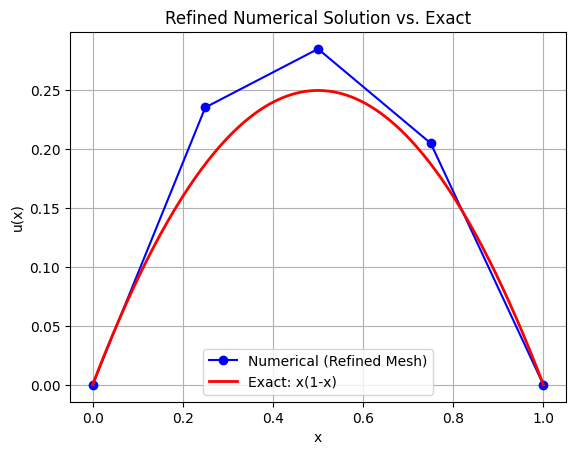

Matrix([
[             0.25],
[0.611111111111111],
[0.972222222222222],
[              1.0],
[              0.5]])

In [174]:
solve(2)[2]

[0. 0.]


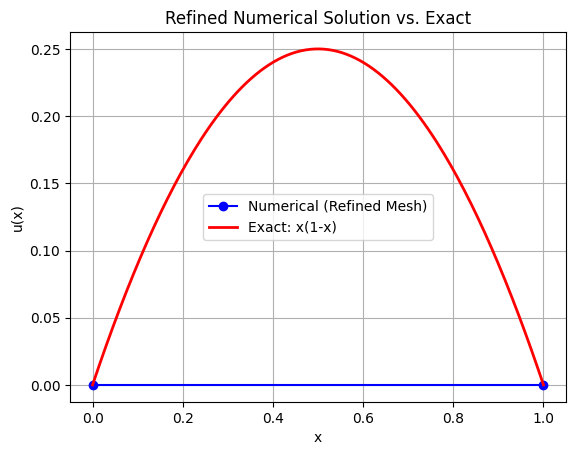

[0.         0.26666667 0.        ]


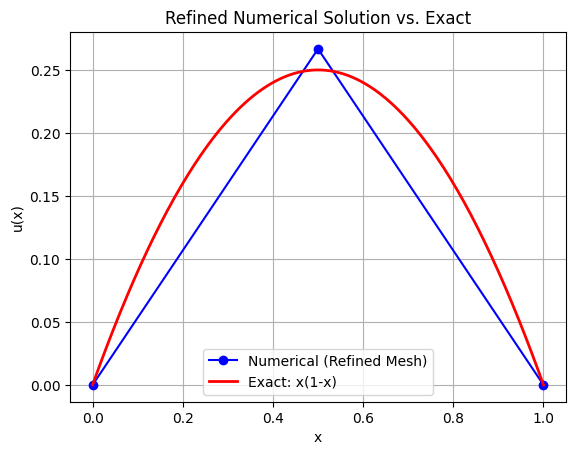

[0.         0.23557692 0.28525641 0.20512821 0.        ]


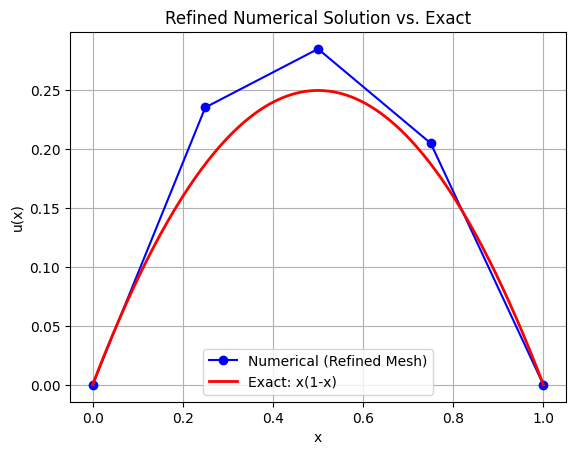

ValueError: setting an array element with a sequence.

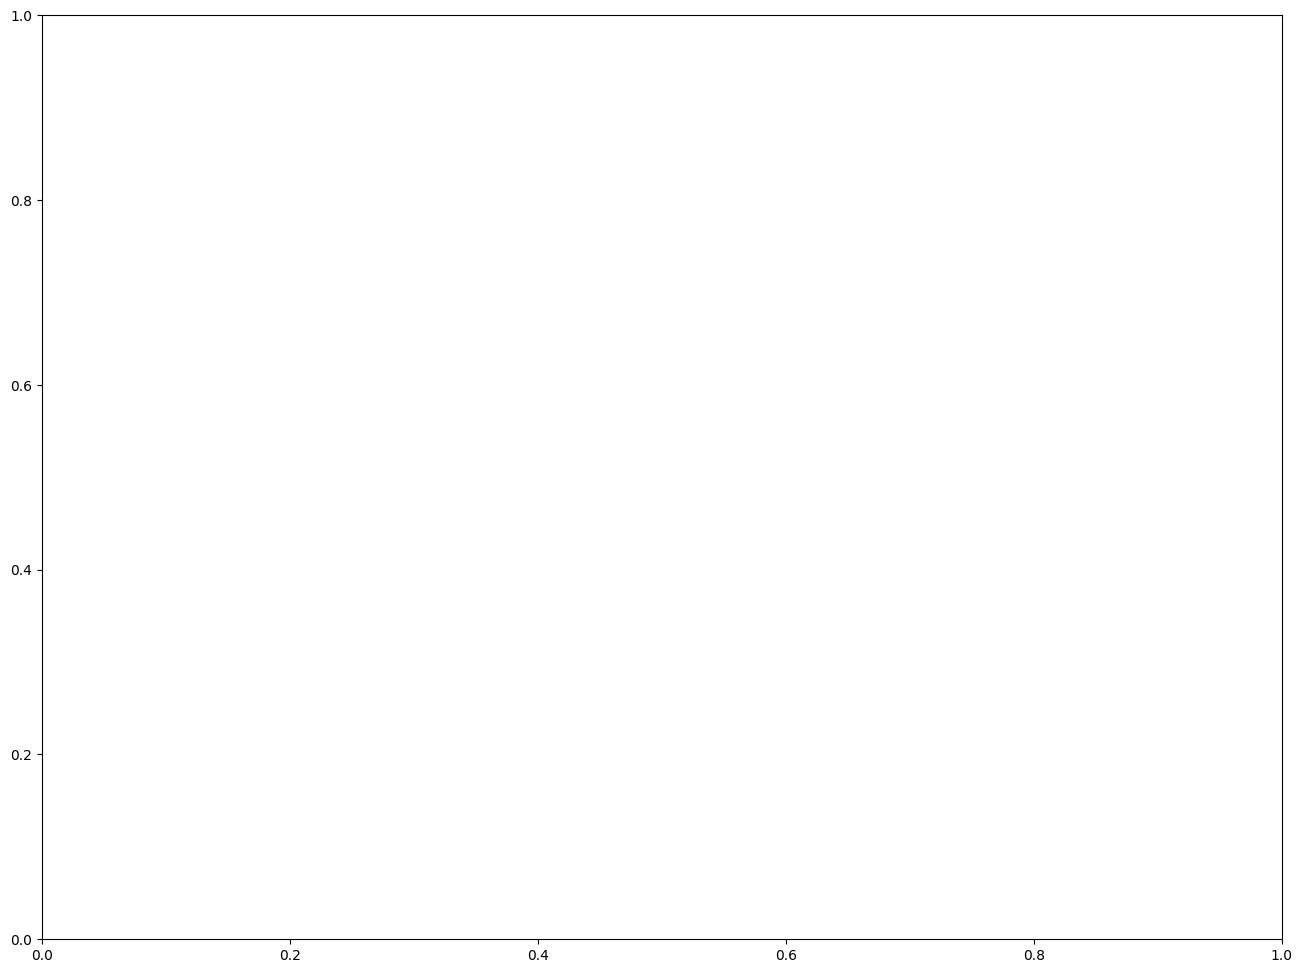

In [ ]:
import matplotlib.pyplot as plt

l_list = list(range(3))
def errordf(llist):
    error = []
    for l in llist:
        logerror = solve(l)
        error.append({'l': l, 'log error': logerror})
    
    df_errors = pd.DataFrame(error)
    return df_errors

dataframe = errordf(l_list)
plt.figure(figsize=(16, 12))
plt.plot(dataframe['l'], dataframe['log error'], marker='o', linestyle='-')
plt.xlabel('l')
plt.ylabel('log error')
plt.title('Plot of log error against l')
plt.grid(True)
plt.show()

In [ ]:
dataframe

,l,log error
0,0,0.614600000000000
1,1,0.204273387096774
2,2,0.0989602941176474
3,3,0.0722484375000002
4,4,0.0653749399038467
5,5,0.0638142235008450


In [85]:
0.000488281249999833/0.00195312500000061

0.24999999999983638

In [86]:
def assemble_nodal_values(C):
    """
    Given:
      C = [U_1, U_2, ..., U_{N-1}]  from the system solve
    Returns:
      U_full = [U_0, U_1, U_2, ..., U_{N-1}, U_N]  (with BCs)
    """
    N_minus_1 = len(C)          # number of interior unknowns
    U_full = [0]*(N_minus_1+2)  # +2 for endpoints
    U_full[0] = 0.0            # Dirichlet BC at x_0
    U_full[-1] = 0.0           # Dirichlet BC at x_N
    
    # Fill in interior:
    for i in range(N_minus_1):
        U_full[i+1] = C[i]
    
    return U_full

In [87]:
nodal = assemble_nodal_values(c_sol)
x_nodal = np.array(mesh, dtype=float)
u_nodal = np.array(nodal, dtype=float)

NameError: name 'c_sol' is not defined